# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.sql.functions import desc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import functions as F
from pyspark.sql.functions import col , column, lit
import datetime
from time import time


import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC, RandomForestClassifier

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Our First Spark SQL Example").getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'Our First Spark SQL Example'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '20503f122d82'),
 ('spark.driver.port', '38861'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1575210905603')]

In [4]:
path='mini_sparkify_event_data.json'

In [5]:
user_log = spark.read.json(path)

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
user_log_valid = user_log.dropna(how="any", subset=["userId", "sessionId"])
print(f"Number of user log after dropping user id and session id with nan value: {user_log_valid.count()}")
user_log_valid=user_log_valid.filter(user_log_valid["userId"]!="")
print(f"Number of user log after dropping invalid user Id: {user_log_valid.count()}")

Number of user log after dropping user id and session id with nan value: 286500
Number of user log after dropping invalid user Id: 278154


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [42]:
user_log_valid.select('page').dropDuplicates().sort("page").show(30, truncate = False)

+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Logout                   |
|NextSong                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



In [8]:
# create downgrade label
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
user_log_valid = user_log_valid.withColumn("downgrade_event", flag_downgrade_event("page"))

# label user who've ever downgraded
windowval = Window.partitionBy('userId')
user_log_valid = user_log_valid.withColumn("downgrade", F.max('downgrade_event').over(windowval))

# create churn label
flag_churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
user_log_valid = user_log_valid.withColumn('churn_event', flag_churn_event('page'))

# label user who churned
windowval = Window.partitionBy('userId')
user_log_valid = user_log_valid.withColumn('churn', F.max('churn_event').over(windowval))

In [9]:
user_churn = user_log_valid.select('userId', col('churn')).dropDuplicates().withColumnRenamed("churn", "label")
user_churn.describe().show()

+-------+------------------+------------------+
|summary|            userId|             label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [10]:
user_churn.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



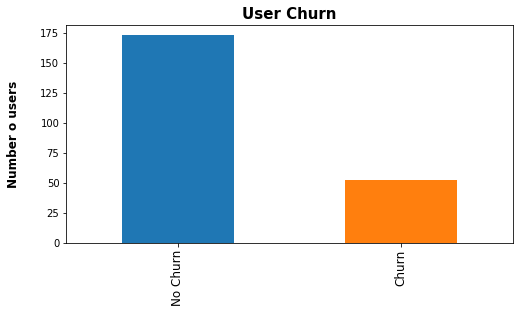

In [11]:
user_churn_pd = user_churn.toPandas()
ax = user_churn_pd['label'].value_counts().plot.bar(figsize=(8,4));
ax.set_title("User Churn", weight='bold', size=15)
ax.set_ylabel("Number o users", labelpad=20, weight='bold', size=12)
ax.set_xticklabels(['No Churn','Churn'], fontsize=12);

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
user_log_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- downgrade_event: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- churn_event: integer (nullable = true)
 |-- churn: integer (nullable = true)



In [13]:
get_hour = udf(lambda x: int(datetime.datetime.fromtimestamp(x/1000.0). hour))
user_log_valid = user_log_valid.withColumn("hour", get_hour(user_log.ts))

In [14]:
soungs_in_hour=user_log_valid.filter(user_log_valid.page =="NextSong").groupby(user_log_valid.hour).count().orderBy(user_log_valid.hour.cast("float"))
soungs_in_hour_pd = soungs_in_hour.toPandas()
soungs_in_hour_pd['hour'] = pd.to_numeric(soungs_in_hour_pd['hour'])

In [15]:
print(f"Hours when user are most active on listening to music: {soungs_in_hour_pd.sort_values('count', ascending=False).head(6)['hour'].values}")

Hours when user are most active on listening to music: [16 17 15 18 19 20]


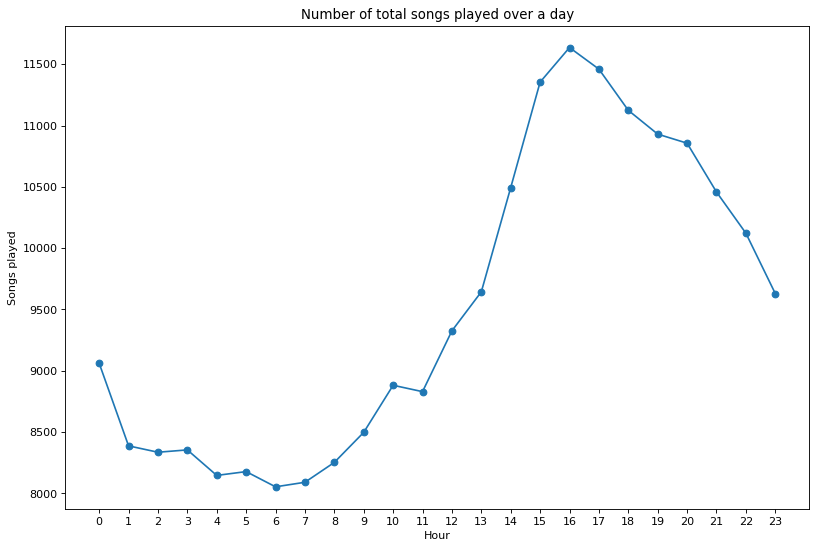

In [39]:
plt.figure(figsize=(12, 8), dpi=80)
plt.scatter(soungs_in_hour_pd["hour"], soungs_in_hour_pd["count"])
plt.plot(soungs_in_hour_pd["hour"], soungs_in_hour_pd["count"])
plt.xticks(soungs_in_hour_pd["hour"])
plt.title("Number of total songs played over a day")
plt.xlabel("Hour");
plt.ylabel("Songs played");

In [17]:
user_log_valid_pd = user_log_valid.toPandas()

In [18]:
user_log_valid_pd.drop(columns=['firstName', 'lastName','method', 'sessionId']).head()

,artist,auth,gender,itemInSession,length,level,location,page,registration,song,status,ts,userAgent,userId,downgrade_event,downgrade,churn_event,churn,hour
0,Sleeping With Sirens,Logged In,F,0,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",NextSong,1538016340000,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,12
1,Francesca Battistelli,Logged In,F,1,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",NextSong,1538016340000,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,13
2,Brutha,Logged In,F,2,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",NextSong,1538016340000,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,13
3,None,Logged In,F,3,NaN,free,"Bridgeport-Stamford-Norwalk, CT",Thumbs Up,1538016340000,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,13
4,Josh Ritter,Logged In,F,4,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",NextSong,1538016340000,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,13
5,LMFAO,Logged In,F,5,183.74485,free,"Bridgeport-Stamford-Norwalk, CT",NextSong,1538016340000,Yes,200,1539004511000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,13
6,OneRepublic,Logged In,F,6,224.67873,free,"Bridgeport-Stamford-Norwalk, CT",NextSong,1538016340000,Secrets,200,1539004694000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,13
7,Dwight Yoakam,Logged In,F,7,239.30730,free,"Bridgeport-Stamford-Norwalk, CT",NextSong,1538016340000,You're The One,200,1539004918000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,13
8,None,Logged In,F,8,NaN,free,"Bridgeport-Stamford-Norwalk, CT",Roll Advert,1538016340000,None,200,1539004961000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,13
9,The Chordettes,Logged In,F,9,142.41914,free,"Bridgeport-Stamford-Norwalk, CT",NextSong,1538016340000,Mr Sandman,200,1539005157000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0,13


Check if http error status could have an influence on user satisfaction. But since the mean value count of 404 error status is only 1.12 per user, and even the maximal occurance is 7, the influence of the status code could be neglected.

In [19]:
user_status = user_log_valid.groupby('userId').pivot("status").agg(F.count("status")).na.fill(0)
user_status.describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|            userId|               200|               307|               404|
+-------+------------------+------------------+------------------+------------------+
|  count|               225|               225|               225|               225|
|   mean|65391.013333333336|           1132.08|            103.04|              1.12|
| stddev|105396.47791907164|1219.4779631055249|111.38672657522015|1.4726070176973318|
|    min|                10|                 6|                 0|                 0|
|    max|                99|              8909|               716|                 7|
+-------+------------------+------------------+------------------+------------------+



# Feature Engineering
After exploring the data, following features were selected for training since they could potentially have an impact of the user churn:

### 1. Feature: user registration time
Generally, user's who have used the service longer tend to be more loyal to the platform.

In [20]:
user_registration = user_log_valid \
    .select('userId','registration','ts') \
    .withColumn('lifetime',(user_log_valid.ts-user_log_valid.registration)) \
    .groupBy('userId') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', (col('lifetime')/1000/3600/24).alias('registration_days'))
user_registration.describe().show()

+-------+------------------+-------------------+
|summary|            userId|  registration_days|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|   79.8456834876543|
| stddev|105396.47791907164|  37.66147001861254|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+



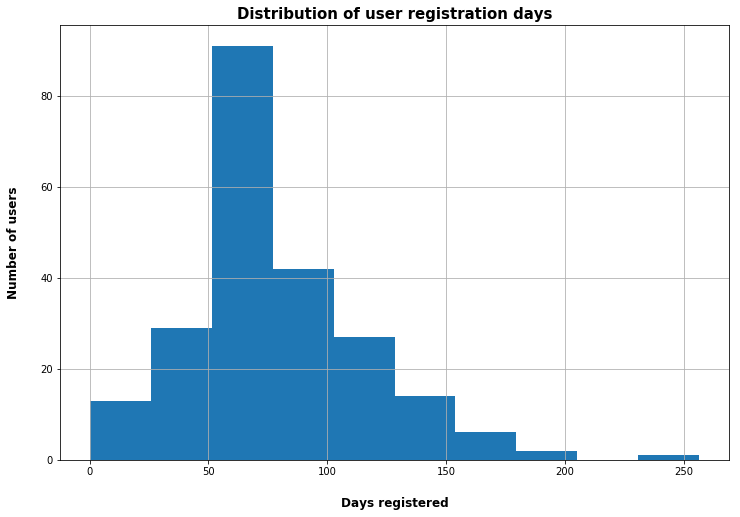

In [21]:
ax = user_registration.toPandas().hist(figsize=(12,8))[0]

for x in ax:
    x.set_title("Distribution of user registration days", weight='bold', size=15)
    x.set_ylabel("Number of users", labelpad=20, weight='bold', size=12)
    x.set_xlabel("Days registered", labelpad=20, weight='bold', size=12)


### 2. Feature: Number of thumbs down
This could indicate if a user does not likes the music or service we are providing.

In [22]:
user_thumbs_down = user_log_valid.select('userID','page').where(user_log_valid.page == 'Thumbs Down').groupBy('userID') \
    .count().withColumnRenamed('count', 'num_thumbs_down')
user_thumbs_down.show(5)

+------+---------------+
|userID|num_thumbs_down|
+------+---------------+
|100010|              5|
|200002|              6|
|    51|             21|
|   124|             41|
|     7|              1|
+------+---------------+
only showing top 5 rows



### 3. Feature: Number of thumbs up
This could indicate that a user likes the music or service we are providing.

In [23]:
user_thumbs_up = user_log_valid.select('userID','page').where(user_log_valid.page == 'Thumbs Up').groupBy('userID') \
    .count().withColumnRenamed('count', 'num_thumbs_up')

### 4. Feature: Number of friends added
If our users are able to share music with their friends, it will likely improve user's satisfaction.

In [24]:
user_num_friends = user_log_valid.select('userID','page').where(user_log_valid.page == 'Add Friend').groupBy('userID') \
    .count().withColumnRenamed('count', 'num_friends') 

### 5. Feature: Number of songs added to playlist
If our user add more songs to their playlist, it shows that they can find music they like on Sparkify.

In [25]:
user_add_playlist = user_log_valid.select('userID','page').where(user_log_valid.page == 'Add to Playlist') \
    .groupBy('userID').count().withColumnRenamed('count', 'num_add_to_playlist')

### 6. Feature: Number of songs listened
With the same reason as above, this is a also a good feature which indicates if our user can find music they like on Sparkify. 

In [26]:
user_num_songs = user_log_valid.dropna(subset=['song']).groupby('userId').agg(F.count("song")).withColumnRenamed('count(song)', 'num_songs')
user_num_songs.describe().show()

+-------+------------------+------------------+
|summary|            userId|         num_songs|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|1013.8133333333334|
| stddev|105396.47791907164|1104.9607785540886|
|    min|                10|                 3|
|    max|                99|              8002|
+-------+------------------+------------------+



### 7. Feature: Listening time
This indicates if our user are enjoying the music we provide.

In [27]:
user_listen_time = user_log_valid.select('userID','length').groupBy('userID').sum().withColumnRenamed('sum(length)', 'listen_time')
user_listen_time.describe().show()


+-------+------------------+------------------+
|summary|            userID|       listen_time|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|252558.32065155543|
| stddev|105396.47791907164| 275396.4038847635|
|    min|                10|         691.66884|
|    max|                99|1991154.9155799907|
+-------+------------------+------------------+



### 8. Feature: Number of artists listened
This shows whether the platform provides a variety of artists that the user likes.

In [28]:
user_num_artist = user_log_valid.filter(user_log_valid.artist.isNotNull()).select("userId", "artist") \
    .dropDuplicates() \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "artist_count")
user_num_artist.show(5)

+------+------------+
|userId|artist_count|
+------+------------+
|100010|         252|
|200002|         339|
|   125|           8|
|    51|        1385|
|   124|        2232|
+------+------------+
only showing top 5 rows



### 9. Feature: Gender
Different gender could have different cosuming behaviour, so we could also include this as a feature

In [29]:
user_gender = user_log_valid.select("userId", "gender").dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender')
user_gender.describe().show()

+-------+------------------+-------------------+
|summary|            userId|             gender|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.5377777777777778|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [30]:
user_gender = user_gender.withColumn("gender", col("gender").cast("int"))

### 10. Feature: average time per session
A user that spends more time per session is likely to be more satisfied with our service, and would not want to cancel the membership.

In [31]:
user_session_time = user_log_valid.groupBy(["userId", "sessionId"]) \
                .agg(((F.max(user_log_valid.ts)-F.min(user_log_valid.ts))/(1000*60))
                .alias("sessionTime"))
user_avg_session = user_session_time.groupby("userId") \
                    .agg(F.avg(user_session_time.sessionTime).alias("avgSessTime"))
user_avg_session.describe().show()

+-------+------------------+------------------+
|summary|            userId|       avgSessTime|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336| 288.1659840733499|
| stddev|105396.47791907164|176.84244472357116|
|    min|                10|               7.0|
|    max|                99|            1179.9|
+-------+------------------+------------------+



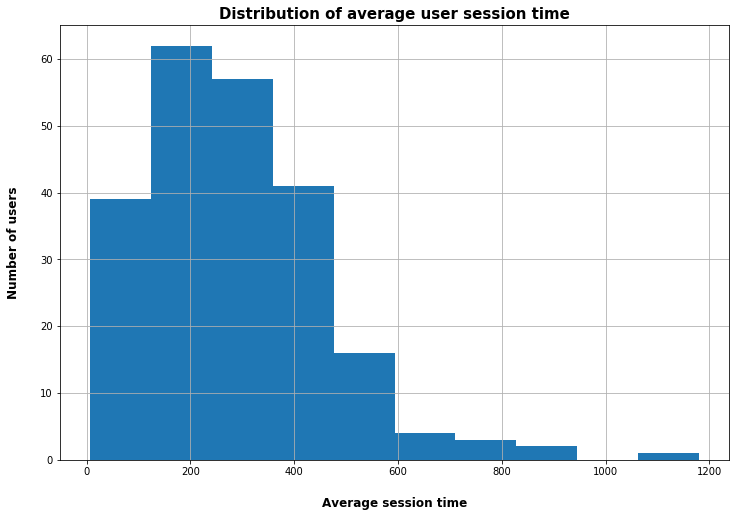

In [41]:
ax = user_avg_session.toPandas().hist(figsize=(12,8))[0]
for x in ax:
    x.set_title("Distribution of average user session time", weight='bold', size=15)
    x.set_ylabel("Number of users", labelpad=20, weight='bold', size=12)
    x.set_xlabel("Average session time", labelpad=20, weight='bold', size=12)

### Group all features and the label together for training

In [43]:
data = user_registration \
    .join(user_thumbs_down,'userID','outer') \
    .join(user_thumbs_up,'userID','outer') \
    .join(user_num_friends,'userID','outer') \
    .join(user_add_playlist,'userID','outer') \
    .join(user_num_songs,'userID','outer') \
    .join(user_listen_time,'userID','outer') \
    .join(user_num_artist,'userID','outer') \
    .join(user_gender,'userID','outer') \
    .join(user_avg_session, 'userID', 'outer') \
    .join(user_churn,'userID','outer') \
    .drop('userID') \
    .fillna(0)

data.show(5)

+------------------+---------------+-------------+-----------+-------------------+---------+------------------+------------+------+------------------+-----+
| registration_days|num_thumbs_down|num_thumbs_up|num_friends|num_add_to_playlist|num_songs|       listen_time|artist_count|gender|       avgSessTime|label|
+------------------+---------------+-------------+-----------+-------------------+---------+------------------+------------+------+------------------+-----+
|  55.6436574074074|              5|           17|          4|                  7|      275| 66940.89735000003|         252|     0|154.48333333333332|    0|
| 70.07462962962963|              6|           21|          4|                  8|      387| 94008.87593999993|         339|     1|266.40000000000003|    0|
| 71.31688657407408|              0|            0|          0|                  0|        8|2089.1131000000005|           8|     1|29.566666666666666|    1|
|131.55591435185184|             41|          171|        

# Modeling

Now we will perform train, test and validation data split on the dataset above, and test following different machine learning models with 3-fold cross-validation and compare the results:

* Random Forest Classifier
* Support Vector Classifier
* Gradient-Boost Tree Classifier

As for the metric, we decided for the F1 score, since the churned user is a small subset.

In [44]:
cols = ['registration_days', 'num_thumbs_down', 'num_thumbs_up', 'num_friends', 'num_add_to_playlist', 'num_songs', 'listen_time',
       'artist_count', 'gender']
assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data = assembler.transform(data)

In [45]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalarModel = scaler.fit(data)
data = scalarModel.transform(data)

In [46]:
train_data, val_data, test_data = data.randomSplit([0.6, 0.2, 0.2], seed=8)

In [55]:
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder().build()

### Support Vector Machine

In [56]:
svm = LinearSVC(maxIter=10)
crossval_svm = CrossValidator(estimator=svm, estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator, numFolds=3)

In [57]:
start = time()
cvModel_svm = crossval_svm.fit(train_data)
end = time()
print(f'The Training time of SVM is {end - start} s.')

The Training time of SVM is 768.5246489048004 s.


In [58]:
results_svm = cvModel_svm.transform(val_data)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('SVM results:')
svm_accuracy = evaluator.evaluate(results_svm, {evaluator.metricName: "accuracy"})
svm_f1 = evaluator.evaluate(results_svm, {evaluator.metricName: "f1"})
print(f'Accuracy: {svm_accuracy}')
print(f'F1 Score:{svm_f1}')
end = time()
print(f'Training and evaluation time of SVM is {end - start} s.')

SVM results:
Accuracy: 0.7619047619047619
F1 Score:0.6589446589446589
Training and evaluation time of SVM is 908.7257239818573 s.


### Random Forest Classifier

In [59]:
rf = RandomForestClassifier()
crossval_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator, numFolds=3)

In [60]:
start = time()
cvModel_rf = crossval_rf.fit(train_data)
end = time()
print(f'The Training time of Random Forest is {end - start} s.')

The Training time of Random Forest is 660.6570003032684 s.


In [61]:
results_rf = cvModel_rf.transform(val_data)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Random Forest results:')
rf_accuracy = evaluator.evaluate(results_rf, {evaluator.metricName: "accuracy"})
rf_f1 = evaluator.evaluate(results_rf, {evaluator.metricName: "f1"})
print(f'Accuracy: {rf_accuracy}')
print(f'F1 Score:{rf_f1}')
end = time()
print(f'Training and evaluation time of Random Forest is {end - start} s.')

Random Forest results:
Accuracy: 0.7857142857142857
F1 Score:0.7577639751552795
Training and evaluation time of Random Forest is 800.4227888584137 s.


### Gradient Boost Trees

In [48]:
gbt = GBTClassifier(maxIter=10,seed=42)

crossval_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator, numFolds=3)

In [49]:
start = time()
cvModel_gbt = crossval_gbt.fit(train_data)
end = time()
print(f'The Training time of Gradient Boost Trees is {end - start} s.')

The Training time of Gradient Boost Trees is 1047.8880410194397 s.


In [51]:
results_gbt = cvModel_gbt.transform(val_data)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
gbt_accuracy = evaluator.evaluate(results_gbt, {evaluator.metricName: "accuracy"})
gbt_f1 = evaluator.evaluate(results_gbt, {evaluator.metricName: "f1"})
print(f'Accuracy: {gbt_accuracy}')
print(f'F1 Score:{gbt_f1}')
end = time()
print(f'Training and evaluation time of Gradient Boost Trees is {end - start} s.')

Accuracy: 0.7380952380952381
F1 Score:0.7039337474120082
Training and evaluation time of Gradient Boost Trees is 1297.7649312019348 s.


### Hyper Parameter Tuning
After picking a model from previous step, we will use hyperparmeter tuning.

In [63]:
paramGrid_gbt = ParamGridBuilder().addGrid(gbt.maxDepth,[5, 10]).build()
#addGrid(gbt.maxIter, [10,15]) \
    
crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=f1_evaluator,
                          numFolds=3)
start = time()
cvModel_gbt = crossval_gbt.fit(train_data)
end = time()
print(f'The time for parameter tuning of Gradient Boost Trees is {end - start} s.')
cvModel_gbt.avgMetrics

In [75]:
paramGrid_rf = ParamGridBuilder().addGrid(rf.numTrees, [10, 30]).build()
    
crossval_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=f1_evaluator,
                          numFolds=3)
start = time()
cvModel_rf = crossval_rf.fit(train_data)
end = time()
print(f'The time for parameter tuning of Random Forest Classifier is {end - start} s.')


The time for parameter tuning of Random Forest Classifier is 687.2714653015137 s.


[0.7608783656954934, 0.7384322932494208]

### Best model selection: Gradient Boost Tree

In [78]:
gbt_best_model =  cvModel_gbt.bestModel#GBTClassifier(maxIter=5,seed=42)

In [69]:
start = time()
results_gbt_best = gbt_best_model.transform(val_data)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
gbt_best_accuracy = evaluator.evaluate(results_gbt_best, {evaluator.metricName: "accuracy"})
gbt_best_f1 = evaluator.evaluate(results_gbt_best, {evaluator.metricName: "f1"})
print(f'Accuracy: {gbt_best_accuracy}')
print(f'F1 Score:{gbt_best_f1}')
end = time()
print(f'Evaluation time of best Gradient Boost Trees is {end - start} s.')

Accuracy: 0.7380952380952381
F1 Score:0.7039337474120082
Evaluation time of best Gradient Boost Trees is 124.70504593849182 s.


### Best model selection: Random Forest 

In [ ]:
rf_best_model =  cvModel_rf.bestModel#GBTClassifier(maxIter=5,seed=42)

In [79]:
start = time()
results_rf_best = rf_best_model.transform(val_data)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
rf_best_accuracy = evaluator.evaluate(results_rf_best, {evaluator.metricName: "accuracy"})
rf_best_f1 = evaluator.evaluate(results_rf_best, {evaluator.metricName: "f1"})
print(f'Accuracy: {rf_best_accuracy}')
print(f'F1 Score:{rf_best_f1}')
end = time()
print(f'Evaluation time of best Random forest classifier is {end - start} s.')

Accuracy: 0.8095238095238095
F1 Score:0.7768707482993197
Evaluation time of best Random forest classifier is 123.51000642776489 s.


In [101]:
rf_best_model.extractParamMap()

{Param(parent='RandomForestClassifier_ce3438cf4e36', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_ce3438cf4e36', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_ce3438cf4e36', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_ce3438cf4e36', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_ce3438cf4e36', 

### Analyze Feature Importance
From below chart, we can see that registration time is largely correlating with user churn, which could mean that user's who used the plattform longer are more loyal. But also, user who churned will not have longer registration time, so we need to be careful about how to interpret this result. There are a few other features which have larger influence on user churn prediction, including number of thumbs down, number of songs user added to playlist, and the total time a user spents on listening to music.

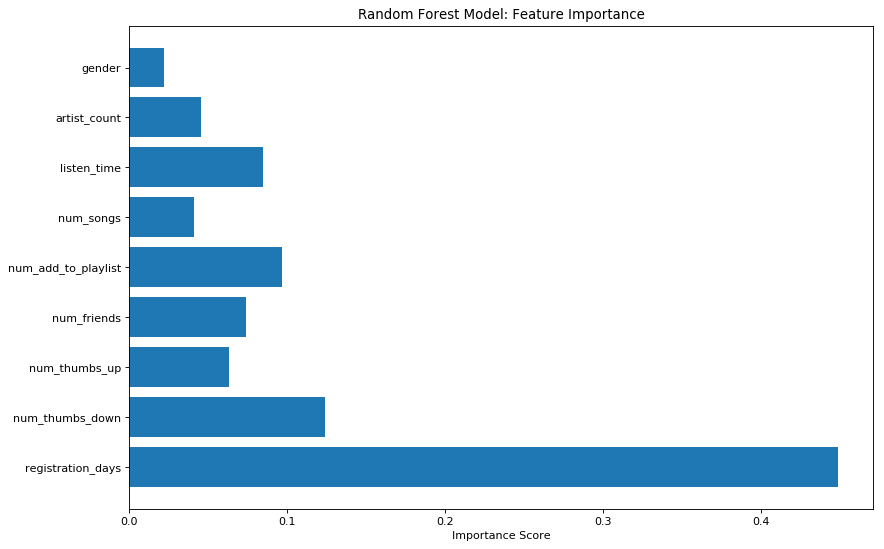

In [103]:
importances = rf_best_model.featureImportances.values
plt.figure(figsize=(12, 8), dpi=80)
y_pos = np.arange(len(cols))
plt.barh(y_pos, importances, align='center')
plt.yticks(y_pos, cols)
plt.xlabel('Importance Score')
plt.title('Random Forest Model: Feature Importance');

## Conclusion

In this project, we utilized PySpark and machine learning algorithms to predict user churn for a fictitious music streaming plattform Sparkify. For computation efficiency reason, we used a smaller sub-dataset of the user log. We performed data cleaning and data exploration, to extract some relevant features which can be used for training of the machine learning algorithms.


We compared 3 different machine learning algorithms including support vector classifier, random forest classifier and gradient boost trees, and used cross validation and grid search to find a model with highest F1 score.

The difficult part of the project for me personally was feature engineering, because besides data wrangling and data visualisation techniques, domain knowledge could also improve feature engineering greatly. For me, I don't have that expertise in music streaming industrie, so the feature I picked are based on a common knowledge of general user behaviour. If we can include domain expertise, we could also improve the prediction in the end. 
